# Analyse des occupations   

In [58]:
### Librairies externes à ajouter le cas échéant à l'environnement Python actif

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx

### Librairies déjà installées avec Python

import pprint
import csv
import sys

from importlib import reload



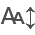

In [59]:
## Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)

In [60]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, "sparql_functions.py")

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## Importer les donnée à analyser

In [61]:
## define SPARQL enpoint
endpoint = "https://ag15yee0az6rmk64.allegrograph.cloud/repositories/ceos"

In [62]:
### Get and count persons occupations

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?occupation ?occupationLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
        {?item wdt:P106 ?occupation.
        ?occupation rdfs:label ?occupLabel
        BIND(LCASE(?occupLabel) as ?occupationLabel)    
          }
}
GROUP BY ?occupation ?occupationLabel 
ORDER BY DESC(?n)
#LIMIT 30
"""

In [63]:
### Execute the query using the local custom fonctions
qr = spqf.get_json_sparql_result(endpoint,query)

In [64]:
### Count and inspect the available occupations
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

195


[['http://www.wikidata.org/entity/Q484876', 'chief executive officer', '2902'],
 ['http://www.wikidata.org/entity/Q43845', 'businessperson', '651'],
 ['http://www.wikidata.org/entity/Q131524', 'entrepreneur', '331']]

In [65]:
### Transform the results into a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r

,uri,label,effectif
0,http://www.wikidata.org/entity/Q484876,chief executive officer,2902
1,http://www.wikidata.org/entity/Q43845,businessperson,651
2,http://www.wikidata.org/entity/Q131524,entrepreneur,331
3,http://www.wikidata.org/entity/Q2462658,manager,314
4,http://www.wikidata.org/entity/Q82955,politician,168
...,...,...,...
190,http://www.wikidata.org/entity/Q774306,surgeon,1
191,http://www.wikidata.org/entity/Q3339059,new york law school,1
192,http://www.wikidata.org/entity/Q2986228,sports commentator,1
193,http://www.wikidata.org/entity/Q806717,bank officer,1


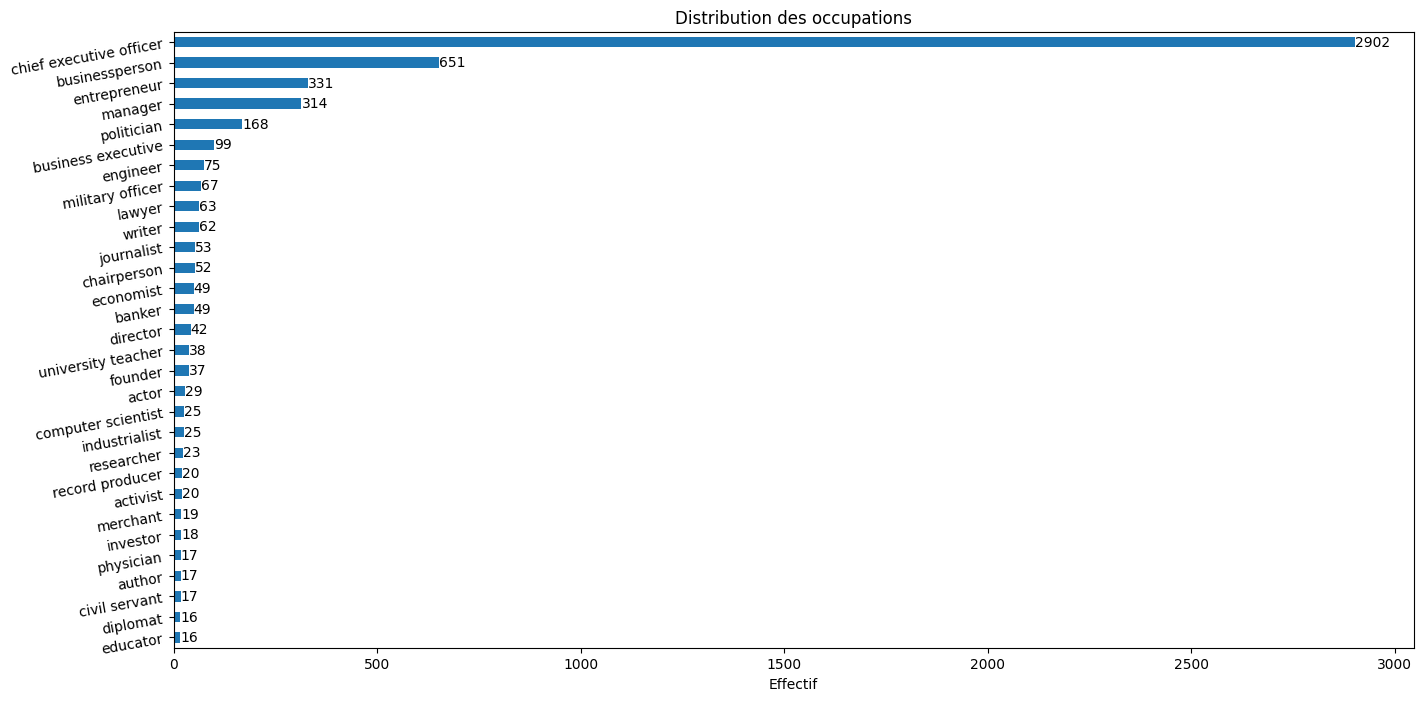

In [66]:
### Bar chart showing distribution by 'occupation': 
# 30 most frequent occupations
ax = df_r['effectif'].head(30).sort_values(ascending=True)\
    .plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(df_r.head(30).label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

In [67]:
l= len(df_r[df_r['effectif'] == 1])
print(l)

73


In [68]:
l= len(df_r[df_r['effectif'] < 10])
print(l)

149


**Comment**: An extreme difference in distribution can be observed: four occupational categories are ten to thirty times larger than the others.

There are 443 occupations with only one person and 800 with less than 10 persons, for a total of 966 different occupations.

### Graphically represent the frequency distribution

There is a wide dispersion of values and a predominant position for activities involving 10 or fewer people

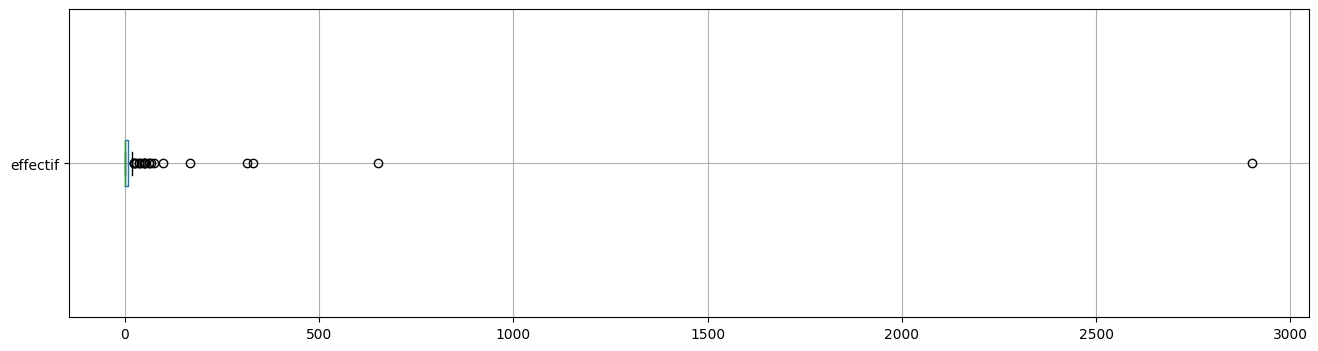

In [69]:
### Distribution des effectifs par occupation
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

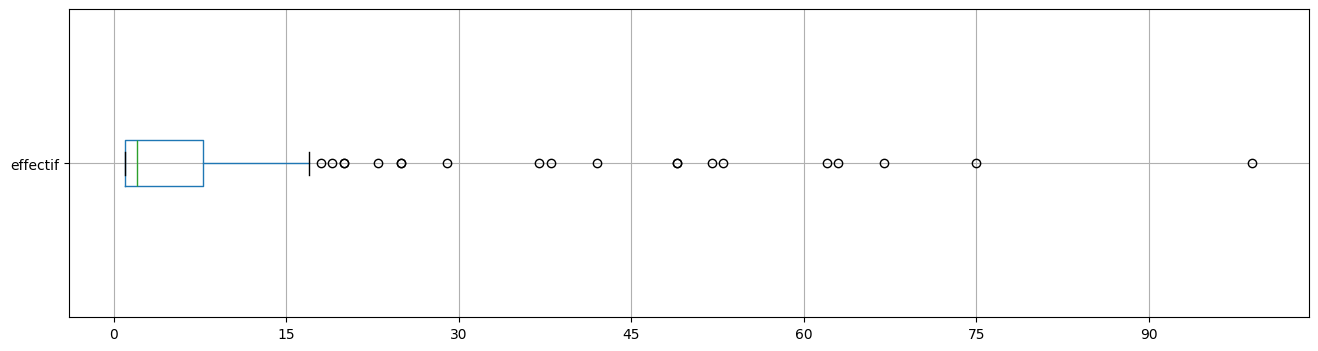

In [70]:
### Distribution des effectifs par occupation
ax = df_r[df_r.effectif<100].boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

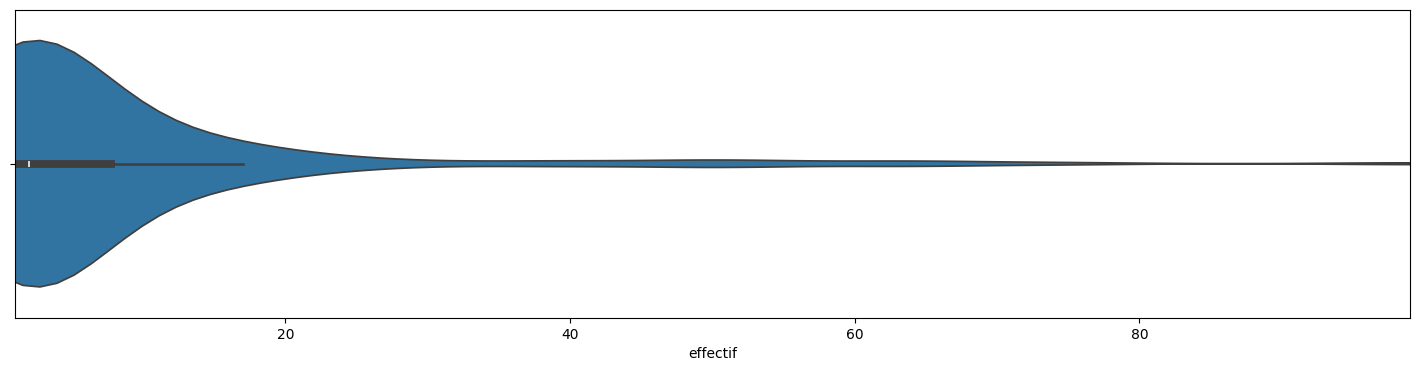

In [71]:
### Represent the density (the total surface has frequency = 1)
# https://seaborn.pydata.org/generated/seaborn.violinplot.html

plt.figure(figsize=(18,4))
d = df_r[df_r.effectif<100].effectif

ax = sns.violinplot(x = d)


### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(d), right=max(d))
plt.show()

### Group by frequency range

In [72]:
### Set the thresholds

ls = [1, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 30000]
print(ls)

[1, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 30000]


In [73]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['seuils'] = pd.cut(df_r['effectif'], ls, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['seuils'] = df_r['seuils'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,uri,label,effectif,seuils
0,http://www.wikidata.org/entity/Q484876,chief executive officer,2902,1000-29999
1,http://www.wikidata.org/entity/Q43845,businessperson,651,500-999
2,http://www.wikidata.org/entity/Q131524,entrepreneur,331,300-499


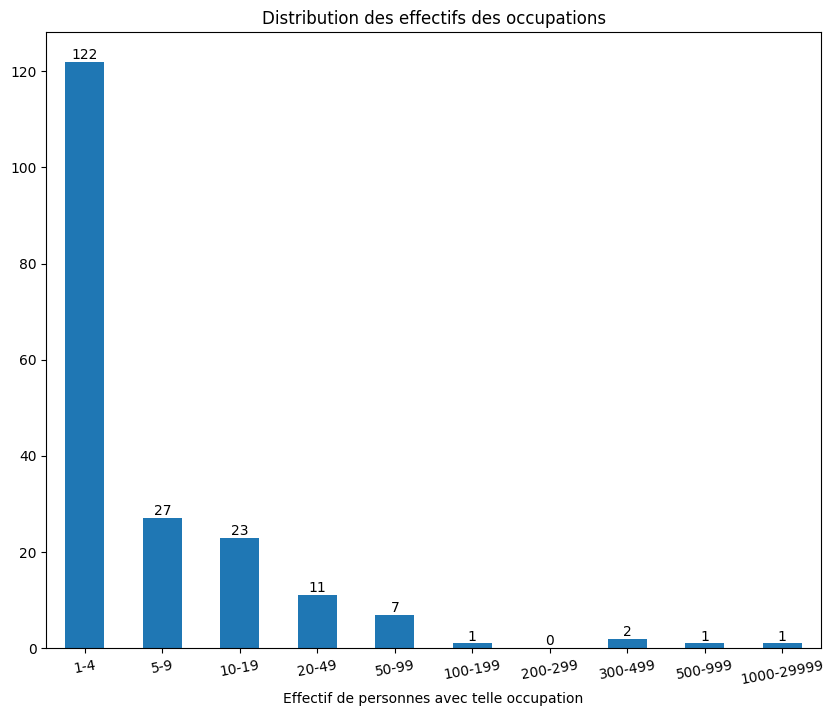

In [74]:
# Plot the grouped distribution

ax = df_r.groupby(by='seuils', observed=False).size()\
    .plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

### Inspect the values

In [75]:
print(df_r[df_r['effectif'] == 1].head(10).label)

122                            trader
123    telecommunications engineering
124                      statistician
125                         pedagogue
126                           vlogger
127        public relations executive
128                        aristocrat
129                    police officer
130                       philosopher
131            broadcasting authority
Name: label, dtype: object


In [76]:
print(df_r[df_r['effectif'] == 5].head(10).label)

64    television personality
65                    orator
66                  minister
67          local politician
68                 architect
69          newspaper editor
70           sports official
71                    farmer
72                 biologist
Name: label, dtype: object


In [77]:
print(df_r[df_r['effectif'] == 10].head(10).label)

43       physicist
44          jurist
45    board member
Name: label, dtype: object


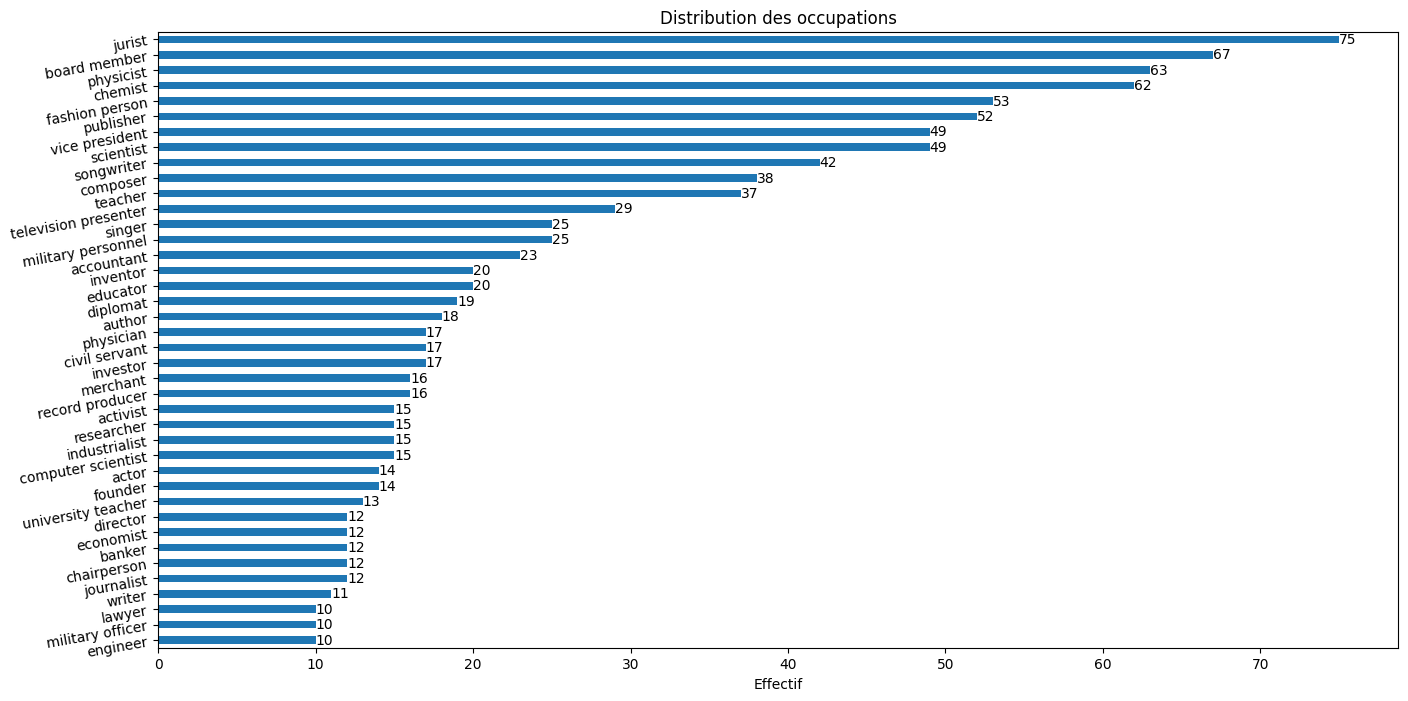

In [78]:
### Bar chart representing the distribution by ‘occupation’ 
# in a given frequency range

d = df_r[(df_r.effectif < 100)&(df_r.effectif > 9)].sort_values(by='effectif',ascending=True).head(40)
ax = d.effectif.plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(d.label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

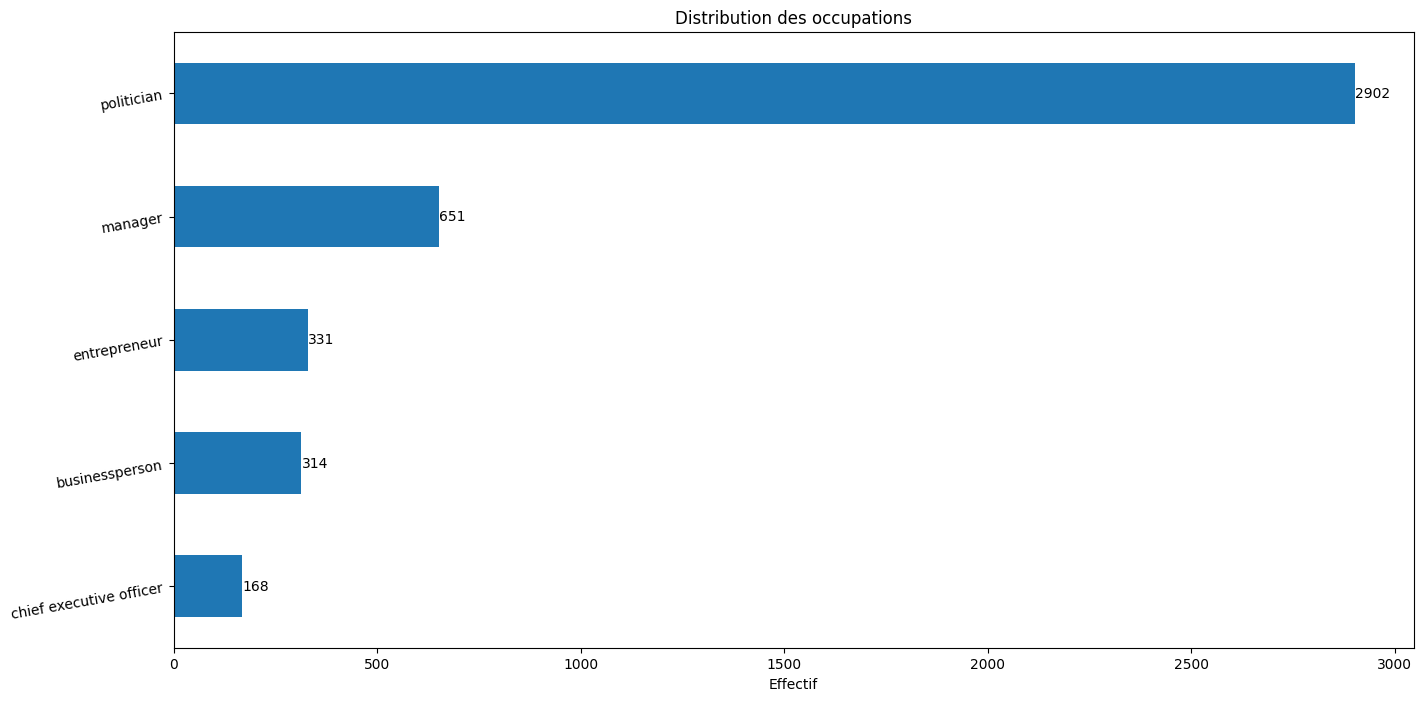

In [79]:
### Bar chart representing the distribution by ‘occupation’ 
# in a given frequency range

d = df_r[df_r.effectif > 100].sort_values(by='effectif',ascending=True)
ax = d.effectif.plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(d.label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

**Comment**

Observation of the typology of occupations reveals a variety that leads to two different types of questions: 
* the specificities of profiles within scientific disciplines
* other activities (artistic, economic, etc.) in their relationship with the disciplines


The aim will be to better define the question or questions we wish to address and to use the information available in Wikidata to create classes.


Another question we could raise is the *changing distribution and configuration over tim*e.

Another question we could ask is the changing distribution and configuration over time. To answer this question, we should add the birth years or generations of the individuals to the characteristics of the occupations.


## Explore the number of occupations per person

In [80]:
### Basic query regarding persons' occupations

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?item ?itemLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
        {?item wdt:P106 ?occupation.
        OPTIONAL {?item rdfs:label ?itemLabel}    
          }
}
GROUP BY ?item ?itemLabel
ORDER BY DESC(?n)
LIMIT 500
"""

In [81]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [82]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]
r

500


[['http://www.wikidata.org/entity/Q107654158', 'DC Glenn', '22'],
 ['http://www.wikidata.org/entity/Q64996103', 'Ricardo Tavera', '22'],
 ['http://www.wikidata.org/entity/Q62766', 'Jay-Z', '16'],
 ['http://www.wikidata.org/entity/Q108233186', 'Derral Eves', '14'],
 ['http://www.wikidata.org/entity/Q216936', 'Sean Combs', '14'],
 ['http://www.wikidata.org/entity/Q22686', 'Donald Trump', '13'],
 ['http://www.wikidata.org/entity/Q118120454', 'Hazar Deniz BG', '12'],
 ['http://www.wikidata.org/entity/Q15615', 'Lil Wayne', '12'],
 ['http://www.wikidata.org/entity/Q6759251', 'Margaret Carter', '10'],
 ['http://www.wikidata.org/entity/Q1515364', 'Gert Verhulst', '10'],
 ['http://www.wikidata.org/entity/Q173175', 'Eddie Jordan', '10'],
 ['http://www.wikidata.org/entity/Q4077009', 'Hayim Baltsan', '9'],
 ['http://www.wikidata.org/entity/Q26132792', 'Jonathan Seaton', '9'],
 ['http://www.wikidata.org/entity/Q70346469', "Kev Chino'", '9'],
 ['http://www.wikidata.org/entity/Q76015769', "D'Vaughn B

In [83]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.head()

,uri,label,effectif
0,http://www.wikidata.org/entity/Q107654158,DC Glenn,22
1,http://www.wikidata.org/entity/Q64996103,Ricardo Tavera,22
2,http://www.wikidata.org/entity/Q62766,Jay-Z,16
3,http://www.wikidata.org/entity/Q108233186,Derral Eves,14
4,http://www.wikidata.org/entity/Q216936,Sean Combs,14


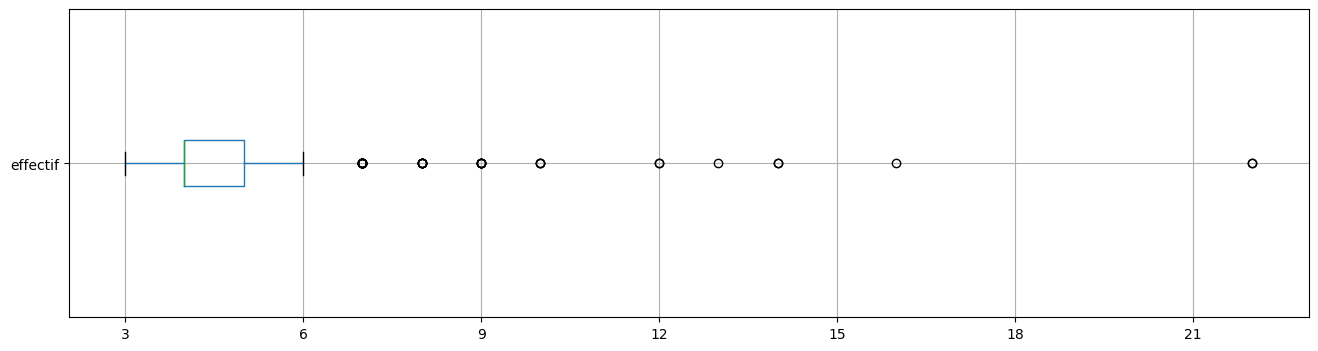

In [84]:
### Distribution of frequencies per person
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

## this fuction avoids ticks with floats instead of integers
#  on the x axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

**Comment**

Most persons have between 6 and 8 occupations, with some outliers

17


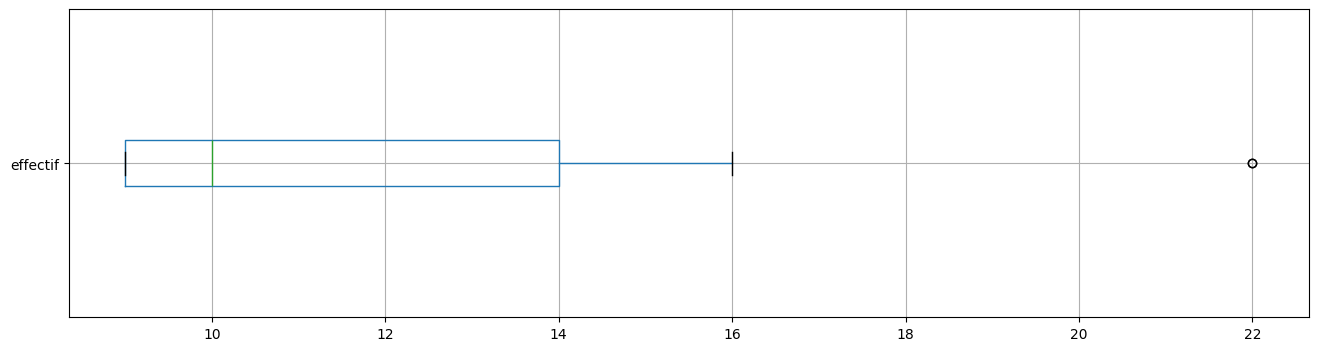

In [85]:
### Distribution des effectifs par occupation

d = df_r[df_r.effectif > 8]
print(len(d))

ax = d.boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [86]:
### Cf. the profiles of these persons in Wikidata
pprint.pprint(d.tail())

                                          uri            label  effectif
12   http://www.wikidata.org/entity/Q26132792  Jonathan Seaton         9
13   http://www.wikidata.org/entity/Q70346469       Kev Chino'         9
14   http://www.wikidata.org/entity/Q76015769    D'Vaughn Bell         9
15   http://www.wikidata.org/entity/Q56697598   Phoenix Rosary         9
16  http://www.wikidata.org/entity/Q107369358  Rodrigo Moreira         9


## Parent occupations

We can try to use the taxonomy of occupations to select relevant occupations.

We therefore go back to the [Import sparqlbook](../../sparqlbooks/wdt_import_occupations.sparqlbook)

In [87]:
query = """
## 

### Simplified query

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>

SELECT DISTINCT 
?occupation ?occupationLabel ?parentField ?parentFieldLabel
?n
          #?parentKnowledgeClassification ?parentKnowledgeClassificationLabel 
          # (SUM(?n) as ?sn)
WHERE {
    GRAPH <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
        {
          SELECT ?occupation ?occupationLabel
          ?parentOccupation (COUNT(*) as ?n)
        
        WHERE
        {
          ?s a wd:Q5;  
              wdt:P106 ?occupation.
          ?occupation rdfs:label ?occupationLabel.
          ?occupation  wdt:P279  ?parentOccupation.
          }  
        GROUP BY ?occupation ?occupationLabel
          ?parentOccupation
        }

        SERVICE <https://query.wikidata.org/sparql>
          {
              # field of parent occupation / instance of /  subclass of  
              ?parentOccupation wdt:P425 / wdt:P31 ?parentField.
              # ?parentField wdt:P279 ?parentKnowledgeClassification.


              #BIND (?occupation as ?occupationLabel)
              BIND (?parentFieldLabel as ?parentFieldLabel)
              # BIND (?parentKnowledgeClassificationLabel as ?parentKnowledgeClassificationLabel)
              SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } 
          }

}
# GROUP BY ?occupation ?occupationLabel ?parentField ?parentFieldLabel
          # ?parentKnowledgeClassification ?parentKnowledgeClassificationLabel 
ORDER BY DESC(?n)
"""

In [88]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [89]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

442


[['http://www.wikidata.org/entity/Q2961975',
  'business executive',
  'http://www.wikidata.org/entity/Q4671286',
  'academic major',
  '99'],
 ['http://www.wikidata.org/entity/Q2961975',
  'business executive',
  'http://www.wikidata.org/entity/Q96247293',
  'type of management',
  '99'],
 ['http://www.wikidata.org/entity/Q2961975',
  'business executive',
  'http://www.wikidata.org/entity/Q627436',
  'field of work',
  '99']]

In [90]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uriOccupation', 'labelOccupation', 'uriDomaine', 'labelDomain', 'size']
# df_r['size'] = df_r.size.apply(lambda x : int(x))
df_r.head()

,uriOccupation,labelOccupation,uriDomaine,labelDomain,size
0,http://www.wikidata.org/entity/Q2961975,business executive,http://www.wikidata.org/entity/Q4671286,academic major,99
1,http://www.wikidata.org/entity/Q2961975,business executive,http://www.wikidata.org/entity/Q96247293,type of management,99
2,http://www.wikidata.org/entity/Q2961975,business executive,http://www.wikidata.org/entity/Q627436,field of work,99
3,http://www.wikidata.org/entity/Q2961975,business executive,http://www.wikidata.org/entity/Q11862829,academic discipline,99
4,http://www.wikidata.org/entity/Q2961975,business executive,http://www.wikidata.org/entity/Q116505632,type of process,99


In [91]:

## [gb_oc['size'] > 4 ]

show(df_r,  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", 
     columnDefs=[{"className": "dt-left", "targets": "_all"}],
     #search={"regex": True, "caseInsensitive": True},
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading ITables v2.3.0 from the init_notebook_mode cell... (need help?)


In [92]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?birthYear ?o ?oLabel ?o1 ?o1Label
WHERE {
    GRAPH <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
        {
            ?item a wd:Q5;
                  wdt:P569 ?birthYear;
                  wdt:P106 ?o.
            ?o a wd:Q12737077;
               wdt:P279 ?o1.
            OPTIONAL {?o rdfs:label ?oLabel}
            OPTIONAL {?o1 rdfs:label ?o1Label}
        }
}
ORDER BY ?birthYear
LIMIT 1000
"""

In [93]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [94]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

1000


[['1770',
  'http://www.wikidata.org/entity/Q806798',
  'banker',
  'http://www.wikidata.org/entity/Q43845',
  'businessperson'],
 ['1770',
  'http://www.wikidata.org/entity/Q484876',
  'chief executive officer',
  'http://www.wikidata.org/entity/Q1072363',
  'chief officer'],
 ['1770',
  'http://www.wikidata.org/entity/Q484876',
  'chief executive officer',
  'http://www.wikidata.org/entity/Q25713832',
  'leader of organization']]

In [95]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['year', 'oc_uri', 'oc_label', 'op_uri', 'op_label']
df_r['year'] = df_r.year.apply(lambda x : int(x))
df_r.head()

,year,oc_uri,oc_label,op_uri,op_label
0,1770,http://www.wikidata.org/entity/Q806798,banker,http://www.wikidata.org/entity/Q43845,businessperson
1,1770,http://www.wikidata.org/entity/Q484876,chief executive officer,http://www.wikidata.org/entity/Q1072363,chief officer
2,1770,http://www.wikidata.org/entity/Q484876,chief executive officer,http://www.wikidata.org/entity/Q25713832,leader of organization
3,1770,http://www.wikidata.org/entity/Q806798,banker,http://www.wikidata.org/entity/Q57774874,bank employee
4,1784,http://www.wikidata.org/entity/Q806798,banker,http://www.wikidata.org/entity/Q43845,businessperson


### Codage par période de vingt-cinq ans

In [96]:
### Créer une liste d'années pour séparer en périodes de 50 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2002, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [97]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['per_25'] = pd.cut(df_r['year'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['per_25'] = df_r['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,year,oc_uri,oc_label,op_uri,op_label,per_25
0,1770,http://www.wikidata.org/entity/Q806798,banker,http://www.wikidata.org/entity/Q43845,businessperson,1751-1775
1,1770,http://www.wikidata.org/entity/Q484876,chief executive officer,http://www.wikidata.org/entity/Q1072363,chief officer,1751-1775
2,1770,http://www.wikidata.org/entity/Q484876,chief executive officer,http://www.wikidata.org/entity/Q25713832,leader of organization,1751-1775


In [98]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_r.groupby(by='per_25').size()
print(naissances_per)

per_25
1751-1775      4
1776-1800     12
1801-1825     32
1826-1850     57
1851-1875    165
1876-1900    328
1901-1925    402
1926-1950      0
1951-1975      0
1976-2000      0
dtype: int64


C:\Users\laila\AppData\Local\Temp\ipykernel_7428\3570518679.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  naissances_per = df_r.groupby(by='per_25').size()


C:\Users\laila\AppData\Local\Temp\ipykernel_7428\4059671348.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df_r.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))


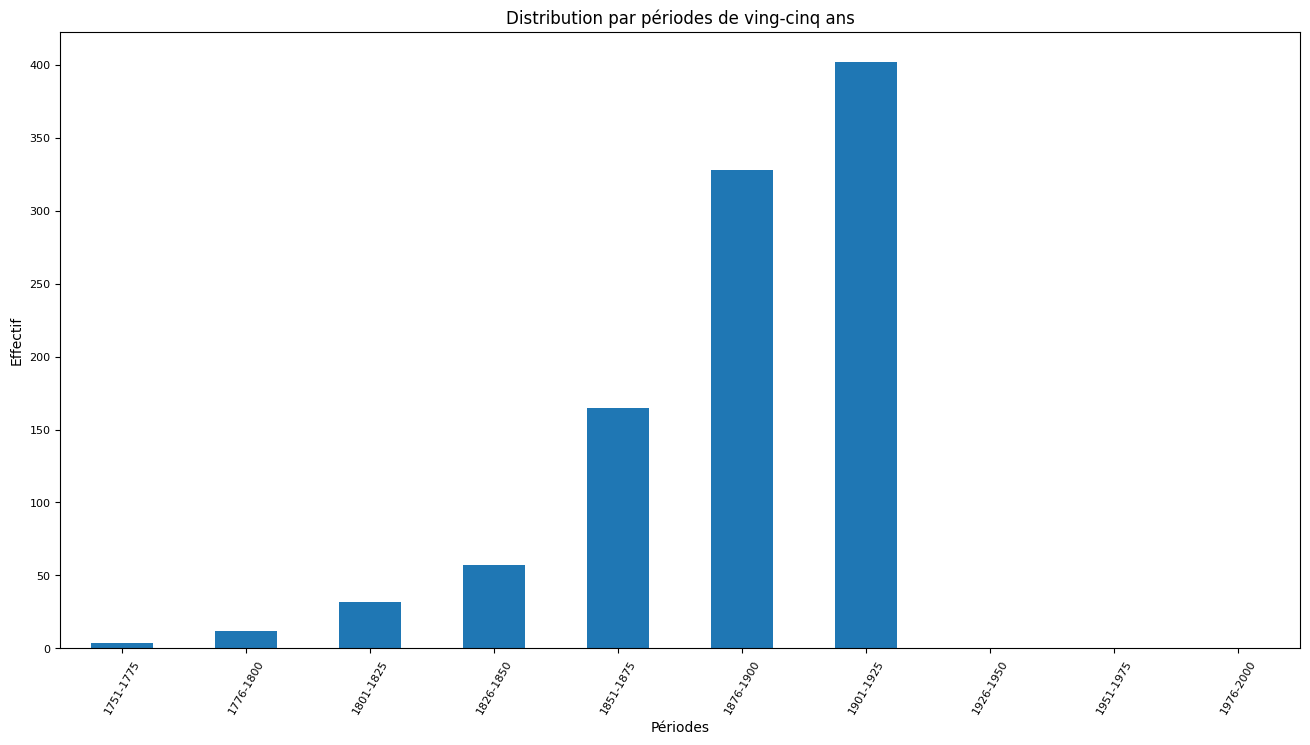

In [99]:
### Diagramme à barres représentant la distribution par 'génération'
ax = df_r.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Distribution par périodes de ving-cinq ans')
plt.show()

In [100]:
### distribution des naissances par périodes de 25 ans
gb_oc = df_r.groupby(by=['oc_label','op_label'], observed=False, as_index=False).size()
print(len(gb_oc))
gb_oc.head()

185


,oc_label,op_label,size
0,,Catholic priest,1
1,,Drug Trafficker,1
2,,Nordic skier,1
3,,abstract game player,1
4,,air force officer,1


In [101]:

## [gb_oc['size'] > 4 ]

show(gb_oc.sort_values(by='size', ascending=False),  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading ITables v2.3.0 from the init_notebook_mode cell... (need help?)


## Paires d'occupations

In [102]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>

## Pour avoir les données avec la personne et l'effectif de toutes les relations
# SELECT DISTINCT ?item ?occupation ?occupationLabel ?occupation_1 ?occupation_1Label

SELECT ?occupation ?occupationLabel ?occupation_1 ?occupation_1Label
WHERE
  {GRAPH <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
     {
      ?item wdt:P106 ?occupation.
      ?item wdt:P106 ?occupation_1.
      ?occupation rdfs:label ?occupationLabel.
      ?occupation_1 rdfs:label ?occupation_1Label.
      FILTER (str(?occupationLabel) < str(?occupation_1Label))
      } 

      }
"""

In [103]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [104]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

4828


[['http://www.wikidata.org/entity/Q484876',
  'chief executive officer',
  'http://www.wikidata.org/entity/Q3908516',
  'entrepreneurship'],
 ['http://www.wikidata.org/entity/Q43845',
  'businessperson',
  'http://www.wikidata.org/entity/Q3908516',
  'entrepreneurship'],
 ['http://www.wikidata.org/entity/Q484876',
  'chief executive officer',
  'http://www.wikidata.org/entity/Q202883',
  'veterinarian']]

In [105]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'uri_1', 'label1_']
df_r.uri = df_r.uri.apply(lambda x : x.replace('http://www.wikidata.org/entity/', ''))
df_r.uri_1 = df_r.uri_1.apply(lambda x : x.replace('http://www.wikidata.org/entity/', ''))
df_r.head()

,uri,label,uri_1,label1_
0,Q484876,chief executive officer,Q3908516,entrepreneurship
1,Q43845,businessperson,Q3908516,entrepreneurship
2,Q484876,chief executive officer,Q202883,veterinarian
3,Q36834,composer,Q1917775,music publishing company
4,Q484876,chief executive officer,Q1917775,music publishing company


In [106]:
list(df_r.columns)

['uri', 'label', 'uri_1', 'label1_']

In [107]:
gr = pd.DataFrame(df_r.groupby(['uri', 'label', 'uri_1', 'label1_']).size())
gr.reset_index(inplace=True)
gr.columns=list(df_r.columns)+['size']
gr.sort_values(by='size', ascending=False).head(40)

,uri,label,uri_1,label1_,size
607,Q43845,businessperson,Q484876,chief executive officer,651
694,Q484876,chief executive officer,Q131524,entrepreneur,331
744,Q484876,chief executive officer,Q2462658,manager,314
813,Q484876,chief executive officer,Q82955,politician,168
559,Q43845,businessperson,Q131524,entrepreneur,124
418,Q2961975,business executive,Q484876,chief executive officer,99
810,Q484876,chief executive officer,Q81096,engineer,75
727,Q484876,chief executive officer,Q189290,military officer,67
773,Q484876,chief executive officer,Q40348,lawyer,63
764,Q484876,chief executive officer,Q36180,writer,62


In [108]:
gr.sort_values(by='size', ascending=False).tail(40)

,uri,label,uri_1,label1_,size
962,Q82955,politician,Q7231725,portfolio manager,1
567,Q43845,businessperson,Q15978655,consultant,1
964,Q832136,business manager,Q43845,businessperson,1
568,Q43845,businessperson,Q15986539,sports official,1
966,Q83307,minister,Q1706722,research fellow,1
967,Q83307,minister,Q82955,politician,1
968,Q836904,brewer,Q131524,entrepreneur,1
41,Q1162163,director,Q4479442,founder,1
970,Q855091,guitarist,Q2462658,manager,1
971,Q855091,guitarist,Q639669,musician,1


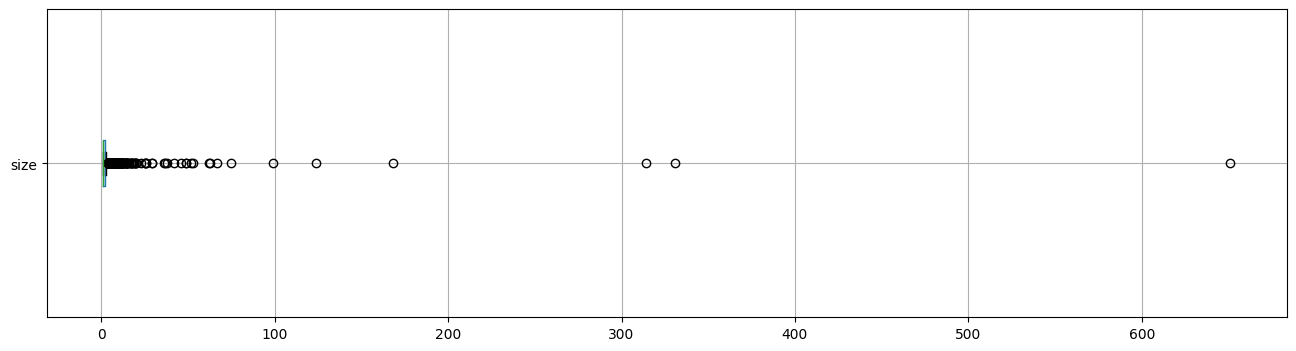

In [109]:
### Distribution des effectifs par occupation
ax = gr.boxplot(column=['size'], vert=False, figsize=(16,4))

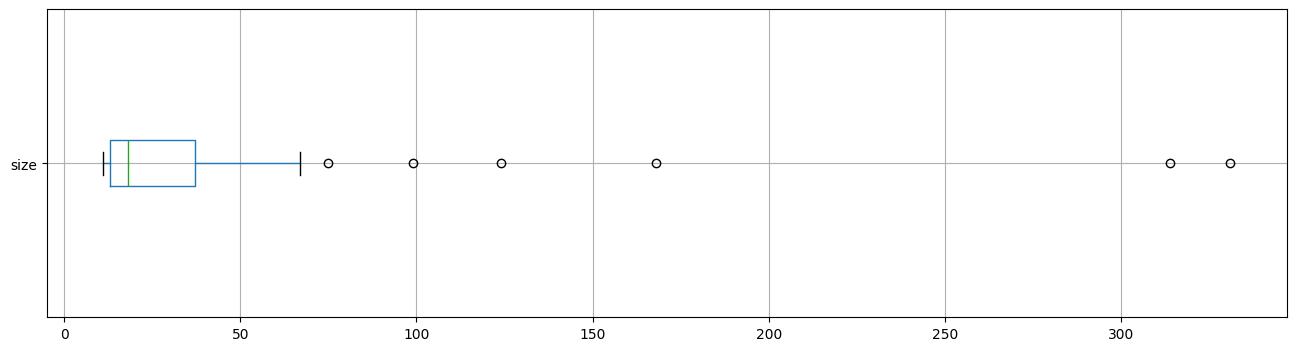

In [110]:
### Distribution des effectifs par occupation
ax = gr[(gr['size']>10) & (gr['size']<500)].boxplot(column=['size'], vert=False, figsize=(16,4))

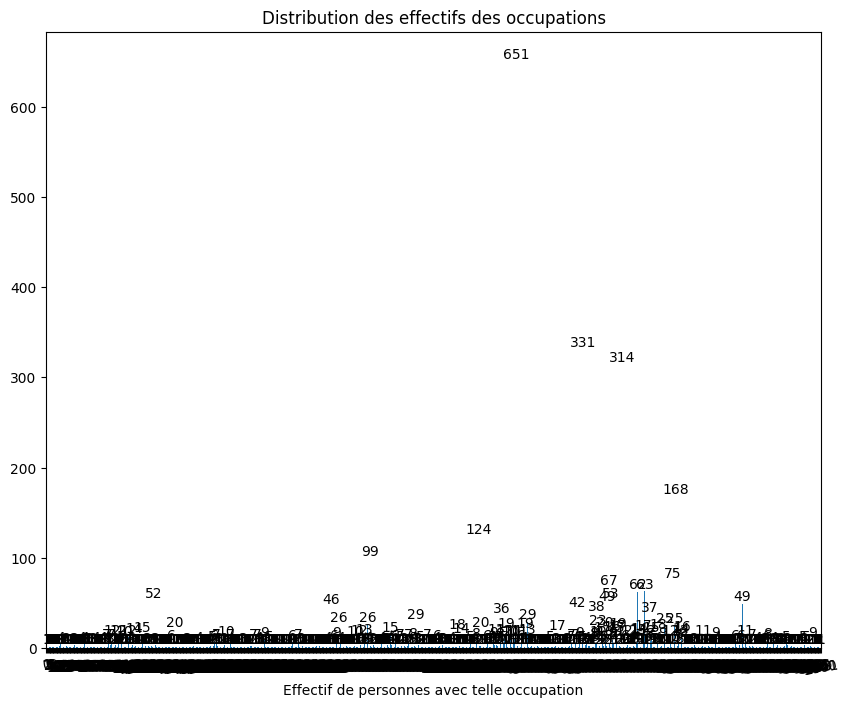

In [111]:
ax = gr['size'].plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

[]

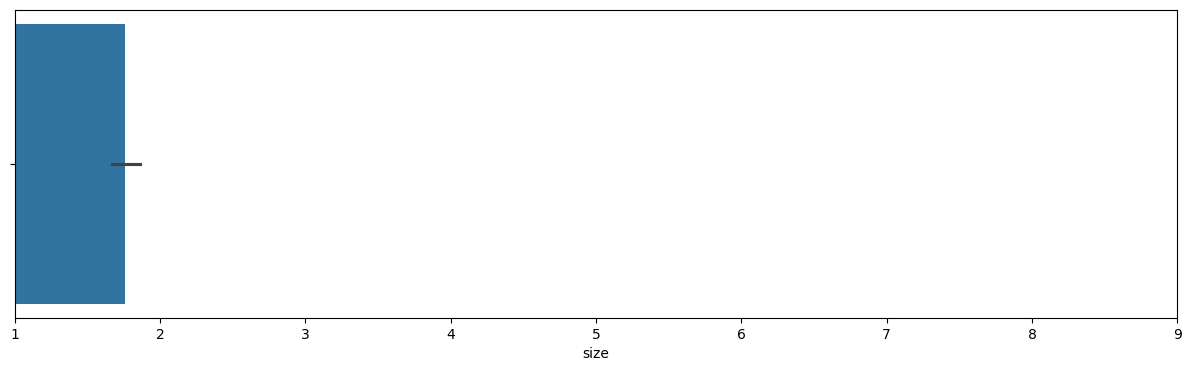

In [112]:
plt.figure(figsize=(15, 4))
d = gr[(gr['size'] > 0) & (gr['size'] < 10)]['size']
#d = gr['size']


ax = sns.barplot(x = d)
ax.set_xlim(left=min(d), right=max(d))

ax.plot()

In [113]:
show(gr[gr['size'] > 4 ].sort_values(by='size', ascending=False),  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading ITables v2.3.0 from the init_notebook_mode cell... (need help?)
